In [1]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
import numpy as np
from IPython.display import HTML, display

sys.path.insert(0, '../')
from flightgoggles.env import *

if __name__ == "__main__":
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSim.yaml") # 30 max_speed multicopterDynamicsSimSpeed
    # for circle number of waypoints = num_waypoints - 1 since the first and last are same
    waypoint_num = 8
    
    theta = np.linspace(0, 2*np.pi, waypoint_num)
    radius = 5
    
    circle_center = np.array([0, -10., -13.])
    x_vals = circle_center[0] + radius*np.cos(theta)
    y_vals = circle_center[1] + radius*np.sin(theta)
    z_vals = circle_center[2] * np.ones(x_vals.size) #for now circle at equal z height
    att_vals = theta
    
    path_coords = np.vstack((x_vals, y_vals, z_vals, att_vals))
    
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = path_coords.T[0][:3],
                          attitude_euler_angle=np.array([0., 0., 0.]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"]
    curr_vel = env.get_state("uav1")["velocity"]
    
    target_pose = path_coords.T[-1]
    
    EPSILON = 2
    stop = False
    
    att_accumulator = np.array([curr_att[2]])
    pos_accumulator = np.array([curr_pos])
    for waypoint_pose in path_coords.T:
        if (waypoint_pose==target_pose).all():
            EPSILON = 0.01
#       print("Heading to ", column, ", from ", curr_pos)
        while np.linalg.norm(curr_pos - waypoint_pose[:3]) > EPSILON:
            collided = env.proceed_waypoint(vehicle_id="uav1",
                                            waypoint_command=waypoint_pose,
                                            duration=0.01)
            curr_pos = env.get_state("uav1")["position"]
            curr_vel = env.get_state("uav1")["velocity"]
            att_accumulator = np.append(att_accumulator, env.get_state("uav1")["attitude_euler_angle"][2])
            pos_accumulator = np.vstack((pos_accumulator, env.get_state("uav1")["position"]))
            if collided:
                stop = True
                break
        if stop:
            print("CRASHED! :(")
            break
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))

    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=400)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()












Final pose [  5.   -10.01 -13.     0.  ]


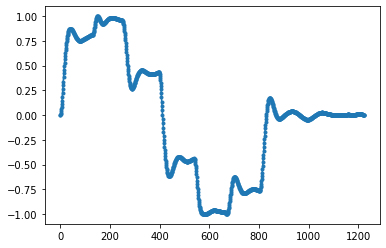

In [6]:
import matplotlib.pyplot as plt
x = np.arange(att_accumulator.size)
y = att_accumulator
# ideally should be sin ?
# plt.plot(x, y, marker='.')
plt.plot(x, np.sin(y), marker='.')

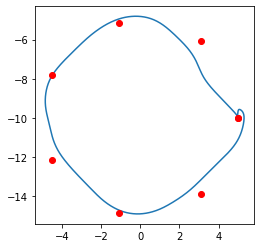

In [7]:
# Orange dots are the waypoints
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(pos_accumulator.T[0], pos_accumulator.T[1])
for column in path_coords.T:
    plt.plot(column[0], column[1], 'or')